<center><h1><b>Proyecto de Curso Aprendizaje Automático</b></h1>
<h2><b>Escuela de Posgrado PUCP</b></h2>
<h2><b>Maestría en Informática</b></h2></center>

**<h2>Importación de Librerías</h2>**


In [13]:
#Procesamiento y manejo de data
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

#Gráficos
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

#Modelos
from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from ANN_util import FeedForwardNeuralNetwork, ANNArchitecture
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Selección hacia atrás
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Librerías varias
from sklearn import pipeline
from sklearn import model_selection
import random

matplotlib.rcParams['figure.dpi'] = 100

**<h2>Lectura de la data</h2>**

El conjunto de datos consta de los niveles de expresión de 77 proteínas que produjeron señales detectables en la parte nuclear del córtex (características continuas). Se tienen 38 ratones  sanos  y  34  ratones trisómicos  organizados en ocho clases (cada uno conformado por entre  7  y  10  ratones).  Por cada ratón se  han  tomado 15  muestras, por  ende, se tendrán 570 y  510 muestras para los ratones sanos y trisómicos respectivamente.

In [3]:
dataset = pd.read_excel("Data_Cortex_Nuclear.xls")

In [4]:
print(f"Las dimensiones del dataset son {dataset.shape}")
dataset.head()

Las dimensiones del dataset son (1080, 82)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**<h2>Preprocesamiento</h2>**

La estrategia que se utilizará para el manejo de datos faltantes será la imputación de los mismos por el estadístico media para cada clase.

**<h3>Eliminación de Características innecesarias y codificación de la clase</h3>**

In [5]:
preprocDataset = dataset.copy()

#Se elimina información redundante "Genotype", "Treatment", "Behavior" que ya están combinadas en la columna clase.
preprocDataset.drop(["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

#Se separan las versiones y números de ratones en otras variables
MouseNumber = preprocDataset.MouseID.apply(lambda x: x.split('_')[0])
MouseVersion = preprocDataset.MouseID.apply(lambda x: x.split('_')[1])

#Se elimina información irrelevante para la tarea de clasificación multiclase
preprocDataset.drop("MouseID", axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder

preprocDataset["class"] = LabelEncoder().fit_transform(preprocDataset["class"])

**<h3>Imputación de datos faltantes</h3>**

Dado que se aplicará validación K-Fold durante la búsqueda y optimización de cada hiperparámetro, se realizará la imputación de datos faltantes durante cada iteración de validación, mediante el uso de un imputador que usa la mediana de cada característica, dicho imputador será agregado al inicio del pipeline de entrenamiento.

**<h2> Separación y etiquetado de datos</h2>**

In [6]:
x = preprocDataset.drop("class",axis=1)
y = preprocDataset["class"]

**<h3>Análisis de separabilidad de la data</h3>**

In [7]:
#Imputacion temporal del dataset para realizar el gráfico T-SNE.
x_imputed = SimpleImputer(strategy="mean").fit_transform(x)
x_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(x_imputed)

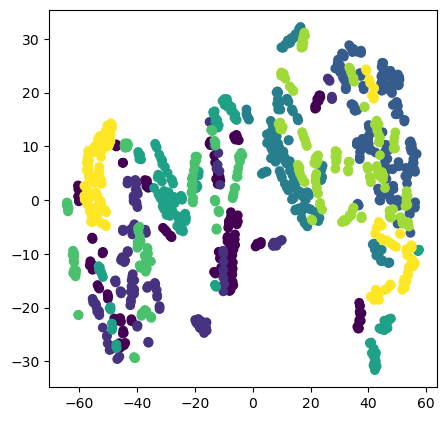

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y)
plt.show()

Se observa del gráfico t-SNE que las clases de los datos están medianamente separados, por tanto, se espera que los modelos a entrenar tengan una precisión razonablemente alta.

**<h2>Separación de conjunto de entrenamiento de conjunto de pruebas</h2>**

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.8,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_test.shape}.")

El tamaño del conjunto de prueba es: (864, 77).
El tamaño del conjunto de prueba es: (216, 77).


## Escalamiento de data

Se utilizará la clase ***pipeline*** para realizar el escalamiento sólo en la data de entrenamiento correspondiente a la validación ***k-fold***, por lo que el escalamiento se realizará previo al entrenamiento de cada modelo.

# Algoritmos a entrenar

## Decision Tree

In [10]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
dt_imputer = SimpleImputer(strategy='mean')
dt_scaler = preprocessing.StandardScaler()
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=0)

dt_pipeline = pipeline.Pipeline([("imputer", dt_imputer), ("scaler", dt_scaler), ("dt", dt_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_dt = {'dt__criterion': ['gini', 'entropy'],
           'dt__max_depth': range(1, 31, 3),
           'dt__min_samples_split': range(2, 40, 1)}

NameError: name 'DecisionTreeClassifier' is not defined

In [114]:
#Busqueda aleatoria
r_search_dt = model_selection.RandomizedSearchCV(dt_pipeline,
                                                 grid_dt,
                                                 n_iter=40,
                                                 n_jobs=-1,
                                                 random_state=0)

r_search_dt.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('dt',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__max_depth': range(1, 31, 3),
                                        'dt__min_samples_split': range(2, 40)},
                   random_state=0)

In [115]:
best_dt_pipeline = r_search_dt.best_estimator_

train_score = best_dt_pipeline.score(x_train, y_train)
test_score = best_dt_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo DT es: {train_score}.")
print(f"La exactitud de prueba para el modelo DT es: {test_score}.")

La exactitud de entrenamiento para el modelo DT es: 1.0.
La exactitud de prueba para el modelo DT es: 0.8425925925925926.


In [118]:
results_dt = pd.DataFrame(r_search_dt.cv_results_['params'])
results_dt['test_score'] = r_search_dt.cv_results_['mean_test_score']
results_dt.head()

,dt__min_samples_split,dt__max_depth,dt__criterion,test_score
0,28,28,entropy,0.774318
1,15,16,entropy,0.807871
2,7,16,entropy,0.839179
3,4,4,gini,0.694408
4,17,19,gini,0.765002


In [122]:
alt.Chart(results_dt, 
          title='Comparacion de performance DT'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Profundidad maxima'),
    alt.Y('test_score', title='Score Medio CV', aggregate='average', scale=alt.Scale(zero=False)),
    color='dt__criterion'
)

alt.Chart(...)

## Random Forest

In [139]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced",random_state=0)

rfc_pipeline = pipeline.Pipeline([("imputer", rfc_imputer),("scaler", rfc_scaler), ("rfc", rfc_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_rfc = {"rfc__n_estimators": range(1,800,40), 
            "rfc__criterion": ['gini', 'entropy'], 
            "rfc__max_depth": range(1,31,3),
            "rfc__min_samples_split": range(2, 40, 1),
            "rfc__min_samples_leaf": range(1, 20, 1)}

In [140]:
#Busqueda aleatoria
r_search_rfc = model_selection.RandomizedSearchCV(rfc_pipeline, 
                                                  grid_rfc, 
                                                  n_iter=40, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'rfc__criterion': ['gini', 'entropy'],
                                        'rfc__max_depth': range(1, 31, 3),
                                        'rfc__min_samples_leaf': range(1, 20),
                                        'rfc__min_samples_split': range(2, 40),
                                        'rfc__n_estimators': range(1, 800, 20)},
                   random_state=0)

In [141]:
best_rfc_pipeline = r_search_rfc.best_estimator_

train_score = best_rfc_pipeline.score(x_train, y_train)
test_score = best_rfc_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo RF es: {train_score}.")
print(f"La exactitud de prueba para el modelo RF es: {test_score}.")

La exactitud de entrenamiento para el modelo RF es: 1.0.
La exactitud de prueba para el modelo RF es: 0.9907407407407407.


In [142]:
results_rfc = pd.DataFrame(r_search_rfc.cv_results_['params'])
results_rfc['test_score'] = r_search_rfc.cv_results_['mean_test_score']
results_rfc.head()

,rfc__n_estimators,rfc__min_samples_split,rfc__min_samples_leaf,rfc__max_depth,rfc__criterion,test_score
0,621,6,12,1,entropy,0.527778
1,581,29,2,16,entropy,0.930556
2,641,24,2,13,gini,0.958333
3,701,9,6,16,gini,0.960648
4,461,28,9,7,entropy,0.909722


In [149]:
alt.Chart(results_rfc, 
          title='Comparacion de performance RFC'
         ).mark_line(point=True).encode(
    alt.X('rfc__n_estimators', title='Numero de estimadores'),
    alt.Y('test_score', title='Score Medio CV', aggregate='average', scale=alt.Scale(zero=False)),
    color='rfc__criterion'
)

alt.Chart(...)

## KNN

In [90]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
knn_imputer = SimpleImputer(strategy='mean')
knn_scaler = preprocessing.StandardScaler()
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_pipeline = pipeline.Pipeline([("imputer", knn_imputer),("scaler", knn_scaler), ("knn", knn_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_knn = {"knn__n_neighbors": range(1,10,1),
            "knn__p": [1, 2, 5],
            "knn__weights": ['uniform', 'distance']}

In [91]:
#Busqueda aleatoria
r_search_knn = model_selection.RandomizedSearchCV(knn_pipeline, 
                                                  grid_knn, 
                                                  n_iter=18, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_knn.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'knn__n_neighbors': range(1, 10),
                                        'knn__p': [1, 2, 5],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=0)

In [92]:
best_knn_pipeline = r_search_knn.best_estimator_

train_score = best_knn_pipeline.score(x_train, y_train)
test_score = best_knn_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo KNN es: {train_score}.")
print(f"La exactitud de prueba para el modelo KNN es: {test_score}.")

La exactitud de entrenamiento para el modelo KNN es: 1.0.
La exactitud de prueba para el modelo KNN es: 0.9953703703703703.


In [153]:
results_knn = pd.DataFrame(r_search_knn.cv_results_['params'])
results_knn['test_score'] = r_search_knn.cv_results_['mean_test_score']
results_knn['metric'] = results_knn['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])

In [154]:
results_knn.sort_values(by=['test_score'], ascending=False)

,knn__weights,knn__p,knn__n_neighbors,test_score,metric
17,distance,1,2,0.995370,Manhattan
5,uniform,2,1,0.991898,Euclidean
10,uniform,5,1,0.983796,Minkowski
4,distance,5,2,0.983796,Minkowski
14,distance,1,6,0.979167,Manhattan
1,distance,2,6,0.974537,Euclidean
16,distance,1,7,0.974537,Manhattan
11,uniform,5,2,0.966435,Minkowski
8,distance,2,8,0.965278,Euclidean
3,uniform,2,5,0.962963,Euclidean


In [104]:
import altair as alt

alt.Chart(results_knn, 
          title='Comparacion de performance KNN'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Numero de Neighbors'),
    alt.Y('test_score', title='Score Medio CV', scale=alt.Scale(zero=False)),
    color='metric'
)

alt.Chart(...)

## Support Vector Machine

In [12]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
gamma = np.logspace(-4, 2, num=20)
C = np.logspace(-4, 2, num=20)

grid_svm = {"model__gamma":gamma, "model__C":C}

In [13]:
#Busqueda aleatoria
r_search =model_selection.RandomizedSearchCV(svm_pipeline, grid_svm, n_iter=40,n_jobs=-1,cv=8, random_state=0)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              SVC(class_weight='balanced',
                                                  random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.3598182...
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'model__gamma': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.274

In [14]:
best_svm_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_svm_pipeline.score(x_train, y_train)
test_score = best_svm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9907407407407407.


## Redes neuronales

Para implementar las redes neuronales, se aplicó un procedimiento de validación cruzada con imputación y escalamiento similar a los utilizados en los entrenamientos de los demás algoritmos, con excepción de que aquí la validación cruzada también se utilizó para validar la inicialización de los pesos de la red neuronal, logrando así la mejor exactitud de validación. En un inicio se hizo una búsqueda aleatoria con una cantidad de capas variable, pero se observo que la data puede ser fácilmente caracterizada con una red neuronal de solo dos capas, por tal motivo el número de capas es fijo en la búsqueda aleatoria.

In [40]:
#Definición de arquitecturas
numberOfUnitsInHiddenLayer = range(8, 50)
numberOfLayers = [2] # Puede ser sustituido por una lista range(2, 7), en este caso no fue necesario
activationFunctionsHidden = ["tanh", "sigmoid","relu"]
activationFunctionsOutput = ["softmax"]

In [42]:
ntries = 10 #Número de búsquedas aleatorias de arquitectura
NUM_EPOCHS = 10000
tries = set() #Set que guardará las arquitecturas ya probadas
random.seed(0)

for i in range(ntries):
    print(f"Iteración de búsqueda aleatoria {i+1}")
    print("---------------------------------------")
    while(True):
        nlayers = random.choice(numberOfLayers)
        
        #Genera una lista de números de neuronas para cada capa, teniendo en cuenta que este número debe ir 
        #decreciendo conforme se llegue a la capa de salida.
        numberOfUnitsPerLayer = [8]#Para generar la salida de 8 clases
        for j in range(nlayers-1):
            index = numberOfUnitsInHiddenLayer.index(numberOfUnitsPerLayer[0])
            newNumberOfUnits = random.choice(numberOfUnitsInHiddenLayer[index:])
            numberOfUnitsPerLayer.insert(0, newNumberOfUnits)
            
        #Seleccionamos aleatoriamente las funciones de activación de cada capa, con excepción de la capa de salida
        #que siempre emplea una función de activación softmax
        numberOfActivationFunctionsPerLayer = [random.choice(activationFunctionsHidden) for j in range(nlayers)]
        numberOfActivationFunctionsPerLayer[-1] = "softmax"

        arch_str = str(numberOfUnitsPerLayer)+str(numberOfActivationFunctionsPerLayer)
        if not (arch_str in tries):
            tries.add(arch_str)
            break
    
    print(f"Arquitectura: {numberOfUnitsPerLayer}. Activation Functions: {numberOfActivationFunctionsPerLayer}\n")
    arch = ANNArchitecture(numberOfUnitsPerLayer, numberOfActivationFunctionsPerLayer)
    redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
    
    redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=NUM_EPOCHS, minibatchSize=64, 
                      verbose=False, numberOfInitializations=1, cv=8, randomState=0)
    

    
print("Fin de búsqueda aleatoria de características con validación cruzada k-fold k=8")

Iteración de búsqueda aleatoria 1
---------------------------------------
Arquitectura: [34, 8]. Activation Functions: ['tanh', 'softmax']

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9953703582286835 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:41. Número de épocas:126.

Costo de entrenamiento:0.010227406397461891. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 2
---------------------------------------
Arquitectura: [33, 8]. Activation Functions: ['sigmoid', 'softmax']

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9953703656792641 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:01:07. Número de épo

La mejor arquitectura encontrada fue una red neuronal con 44 neuronas en la única capa oculta, con función de activación tangente hiperbólica, y 8 en la capa de salida, con una función de activación softmax.

In [44]:
random.seed(0)
 
print(f"Arquitectura: 26-8. Activation Functions: tanh-softmax\n")

arch = ANNArchitecture([26, 8], ["tanh","softmax"])
redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=10000, minibatchSize=64, 
                  verbose=False, numberOfInitializations=1, cv=8, randomState=0)

Arquitectura: 26-8. Activation Functions: tanh-softmax

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9988425895571709 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:41. Número de épocas:132.

Costo de entrenamiento:0.011033134534955025. Exactitud de entrenamiento:1.0.




In [45]:
test_cost = redNeuronal.score(x_test, y_test)
print ("Test SCCE:", test_cost)

Test SCCE: 0.9907407164573669


## Naive Bayes

Se implementará Naive Bayes Gaussiano, se realizará una búsqueda aleatoria para las probabilidades a priori, aunque se puede deducir que el dejar que el algoritmo las cálcule probablemente sea lo óptimo.

In [29]:
random.seed(0)
#Definición de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
naive_imputer = SimpleImputer(strategy='mean')
naive_scaler = preprocessing.StandardScaler()
naive_model = naive_bayes.GaussianNB()
naive_pipeline = pipeline.Pipeline([("imputer",naive_imputer), ("scaler", naive_scaler), ("model", naive_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
priors = [None]

while(len(priors)<1000):
    priorsItem = []
    probabilityLeft = 1
    
    save = True
    for j in range(8):
        prob = random.uniform(0, probabilityLeft)
        if prob <=0.01:
            save = False
            break
        priorsItem.append(prob)
        probabilityLeft -= prob
    
    if (0 not in priorsItem) and save:
        priors.append(priorsItem)

grid_naive = {"model__priors":priors}

In [30]:
#Busqueda de grilla
grid_search =model_selection.GridSearchCV(naive_pipeline, grid_naive, n_jobs=-1,cv=8)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', GaussianNB())]),
             n_jobs=-1,
             param_grid={'model__priors': [None,
                                           [0.42561883196681716,
                                            0.05829981455975992,
                                            0.13413980851894763,
                                            0.08434387305772524,
                                            0.19252358811312115,
                                            0.03680681767912299,
                                            0.012309810167133287,
                                            0.028182217548734585],
                                           [0.40862622118314...
                                            0.03169835559401494,
                                            0.027751

In [31]:
grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', GaussianNB())])

In [32]:
best_naive_pipeline = grid_search.best_estimator_

train_score = best_naive_pipeline.score(x_train, y_train)
test_score = best_naive_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: {train_score}.")
print(f"La exactitud de prueba para el modelo naive Bayes Gaussiano es: {test_score}.")

La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: 0.8032407407407407.
La exactitud de prueba para el modelo naive Bayes Gaussiano es: 0.8148148148148148.


## Regresión Logística

In [14]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lr_imputer = SimpleImputer(strategy='mean')
lr_scaler = preprocessing.StandardScaler()
lr_model = LogisticRegression(penalty="l2", class_weight="balanced", solver="lbfgs", random_state=47, max_iter=400)
lr_pipeline = pipeline.Pipeline([("imputer", lr_imputer), ("scaler", lr_scaler), ("model", lr_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 4, num=401)

grid_lr = {"model__C":C}

In [15]:
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(lr_pipeline, grid_lr, n_iter=40, n_jobs=-1, cv=8, random_state=47)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=400,
                                                                 random_state=47))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 1.04712855e-04, 1.09647820e-04, 1.14815362e-04,
       1.20226443e-04, 1.25892541e-04, 1.31825674...
       3.31131121e+03, 3.46736850e+03, 3.63078055e+03, 3.80189396e+03,
       3.98107171e+03, 4.16869383e+03, 4.36515832e+03, 4.57088190e+03,
       4.78630092e+03, 5.01187234e+03, 5.24807460e+03, 5.49540874e+03,
       5.75439937e+03, 6.02559586e+03, 6.30957344e+03, 6.60693448e+03,
       6.91830

In [16]:
best_lr_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lr_pipeline.score(x_train, y_train)
test_score = best_lr_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el Regresión Logística es: 0.9861111111111112.


### Eliminación hacia atrás

In [19]:
#Definicion de imputación y escalamiento para datos y agrupación en pipeline
imsc_imputer = lr_imputer
imsc_scaler = lr_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])
imsc_pipeline.fit(x_train)

#Aplicación del pipeline para obtener data aplicable para el modelo de eliminación hacia atrás
x_train_imsc = imsc_pipeline.transform(x_train)

#Mejor modelo obtenido para Regresión Logística
best_model = best_lr_pipeline["model"]

#Eliminación hacia atrás para el mejor modelo
rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

#Transformación de datos de entrenamiento
x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Número óptimo de características : 69


In [20]:
#Entrenando con las características óptimas en entrenamiento (como parámetro warm_start es FALSE, se entrena de nuevo)
best_model.fit(x_train_opt, y_train)

#Transformación de datos de prueba
x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Exactitud del modelo en conjuntos de entrenamiento y prueba
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el modelo Regresión Logística es: 0.9814814814814815.


## LightGBM

In [21]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lgbm_imputer = SimpleImputer(strategy='mean')
lgbm_scaler = preprocessing.StandardScaler()
lgbm_model = LGBMClassifier()
lgbm_pipeline = pipeline.Pipeline([("imputer", lgbm_imputer), ("scaler", lgbm_scaler), ("lgbm", lgbm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_lgbm = {"lgbm__max_bin": np.power(2, range(7,10,3)), 
             "lgbm__learning_rate": [2.5e-3,5-3,7.5e-3,1e-2],
             "lgbm__num_leaves": range(250, 500, 25),
             "lgbm__num_iterations": [500]}

In [22]:
lgbm_search = model_selection.RandomizedSearchCV(lgbm_pipeline, grid_lgbm, n_iter=20, n_jobs=-1, cv=8, random_state=47)
lgbm_search.fit(x_train, y_train)

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.0025, 2,
                                                                0.0075, 0.01],
                                        'lgbm__max_bin': array([128], dtype=int32),
                                        'lgbm__num_iterations': [500],
                                        'lgbm__num_leaves': range(250, 500, 25)},
                   random_state=47)

In [23]:
best_lgbm_pipeline = lgbm_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lgbm_pipeline.score(x_train, y_train)
test_score = best_lgbm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo LightGBM: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM: 1.0.
La exactitud de prueba para el modelo LightGBM: 0.9537037037037037.


### Eliminación hacia atrás

In [ ]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
imsc_imputer = lgbm_imputer
imsc_scaler = lgbm_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

x_train_imsc = imsc_pipeline.transform(x_train)

best_lgbm_params = best_model.get_params()
best_model = LGBMClassifier().set_params(**best_lgbm_params)

rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

In [ ]:
best_model.fit(x_train_opt, y_train)

x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")